In [1]:
%%time
%reset -f
import xarray as xr
import regionmask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------- SPECIFY ---------------------------------
region_name = 'Northeast' 
fileOBS = '/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/tas_2m_anom_ERA5_19990101-20211231_data.nc'
fileSIM = '/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/tas_2m_anom_cesm2cam6v2.scenario1_s2s_data.nc'
# --------------------------------- SPECIFY ---------------------------------

states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
region_groups = {
    'South': ['Kansas', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana', 'Mississippi'],
    'Southwest': ['Colorado', 'Arizona', 'Utah', 'New Mexico'],
    'West': ['California', 'Nevada'],
    'Northwest': ['Washington', 'Oregon', 'Idaho'],
    'RockiesPlains': ['Montana', 'Wyoming', 'North Dakota', 'South Dakota', 'Nebraska'],
    'UpperMidwest': ['Minnesota', 'Iowa', 'Wisconsin', 'Michigan'],
    'OhioValley': ['Missouri', 'Illinois', 'Indiana', 'Ohio', 'West Virginia', 'Kentucky', 'Tennessee'],
    'Southeast': ['Alabama', 'Georgia', 'Florida', 'South Carolina', 'North Carolina', 'Virginia'],
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'New York', 'Pennsylvania', 'Maryland', 
                  'Delaware', 'New Jersey', 'Connecticut', 'Rhode Island', 'Massachusetts', 'District of Columbia']
}

ds = xr.open_dataset(fileOBS)
dateArrayOBS = pd.to_datetime(ds['time'], format='%Y%m%d')
varOBS = ds['anom']
maskOBS = states.mask(varOBS)

ds = xr.open_dataset(fileSIM)
initSIM = pd.to_datetime(ds['date'], format='%Y%m%d')
varSIM = ds['anom'][:, 14:21, :, :].mean(axis=1) # -------- specify week34 mean
maskSIM = states.mask(varSIM)
M = len(initSIM)
dateArraySIM = np.zeros((M, 46), dtype='datetime64[D]')
for i in range(46):
    dateArraySIM[:, i] = initSIM + pd.Timedelta(days=i)

R_dict = {}
for region_name in region_groups:
    print(region_name)
    region_maskOBS = maskOBS.isin([states.map_keys(state) for state in region_groups[region_name]])
    anomOBS = varOBS.where(region_maskOBS)
    region_maskSIM = maskSIM.isin([states.map_keys(state) for state in region_groups[region_name]])
    anomSIM = varSIM.where(region_maskSIM)
    R = np.full(len(dateArraySIM), np.nan)
    for i in range(len(dateArraySIM)):
        a = pd.to_datetime(dateArraySIM[i, 14:21])
        b = pd.to_datetime(dateArrayOBS)
        intersection, a_indices, b_indices = np.intersect1d(a, b, return_indices=True)
        X = anomOBS[b_indices, :, :].mean(axis=0)
        Y = anomSIM[i, :, :]
        R[i] = xr.corr(X, Y)
    R_dict[region_name] = R
    print(len(R[R > 0.7]))
    del region_maskOBS, anomOBS, region_maskSIM, anomSIM
    
R_dataset = xr.Dataset()
for region, R_values in R_dict.items():
    R_dataset[region] = xr.DataArray(R_values, dims=["time"])
R_dataset.to_zarr("2mT_ACC_week3_byRegion_data.zarr", mode="w")

South
149
Southwest
65
West
94
Northwest
81
RockiesPlains
130
UpperMidwest
125
OhioValley
137
Southeast
133
Northeast
163
CPU times: user 1min 55s, sys: 8min 44s, total: 10min 40s
Wall time: 12min 38s


(287,)
South: 30.0%
Southwest: 16.7%
West: 19.5%
Northwest: 18.5%
RockiesPlains: 27.2%
UpperMidwest: 25.8%
OhioValley: 25.4%
Southeast: 26.5%
Northeast: 27.5%


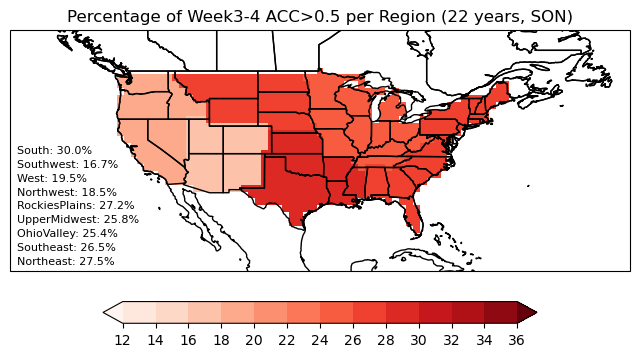

In [198]:
import xarray as xr
import regionmask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

# ------------- Just do this one time, if needed
# ds = xr.open_dataset(fileOBS)
# var = ds['anom'].mean(axis=0)
# mask = states.mask(var)

# ---------------------------------- WARNING --- SPECIFY
dates_pd = pd.to_datetime(dateArraySIM[:, 0])
seasonMask = dates_pd.month.isin([9, 10, 11])
indices = np.where(seasonMask)[0]
print(indices.shape)

ds = xr.open_zarr("2mT_ACC_week34_byRegion_data.zarr")
percent_above_zero = {}
for region in region_groups:
    R = ds[region]
    R = R.isel(time=indices) # ---------------------------------- WARNING --- SPECIFY
    total = R.size
    count = int((R > 0.5).sum().compute())
    percent_above_zero[region] = (count / total) * 100
    print(f"{region}: {percent_above_zero[region]:.1f}%")

values = np.array(list(percent_above_zero.values()))
# bounds = np.arange(round(values.min())-4, round(values.max())+4, 2)
bounds = np.arange(12, 38, 2)

cmap = plt.colormaps.get_cmap('Reds')
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, extend='both')
colors = cmap(norm(values))

plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
for i, (region_name, state_list) in enumerate(region_groups.items()):
    region_color = colors[i]
    custom_cmap = ListedColormap([[0, 0, 0, 0], region_color])
    region_mask = mask.isin([states.map_keys(state) for state in state_list])
    region_mask.where(region_mask).plot(ax=ax, transform=ccrs.PlateCarree(), 
        cmap=custom_cmap, vmin=0, vmax=1, add_colorbar=False)
    ax.text(-139, 37-i*2, "{}: {}%".format(region_name,round(values[i], 1)),
            fontsize=8, color='black', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', linewidth=1)
ax.coastlines()
ax.set_xlim(-140, -50)
ax.set_ylim(20, 55)
plt.title('Percentage of Week3-4 ACC>0.5 per Region (22 years, SON)')

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, boundaries=bounds,
                    ticks=bounds, spacing='proportional',
                    shrink=0.7, pad=0.05, orientation='horizontal')
plt.savefig("2mT_frequency_ACCgt05_week34_SON_map.png", dpi=300)
plt.show()



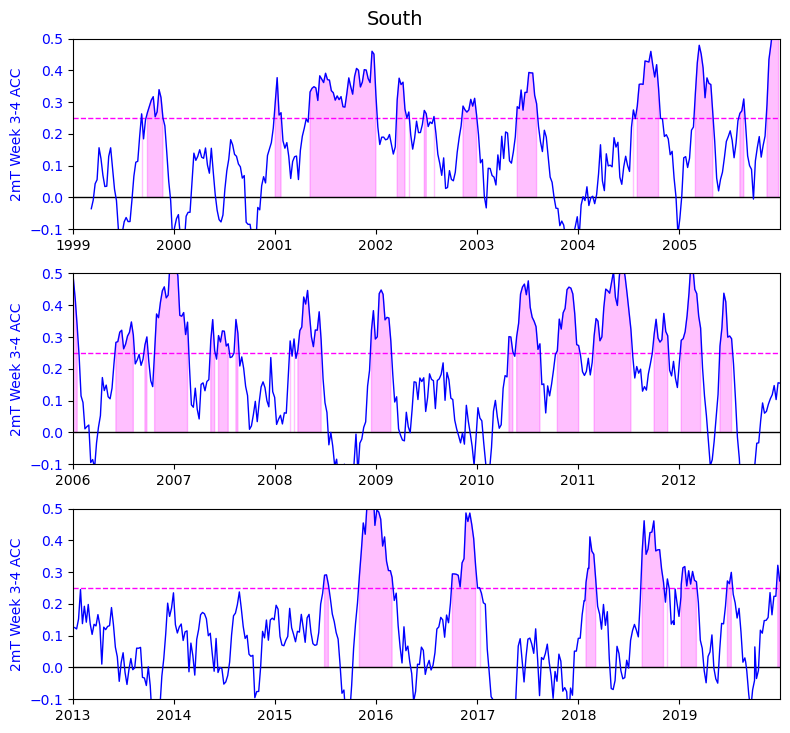

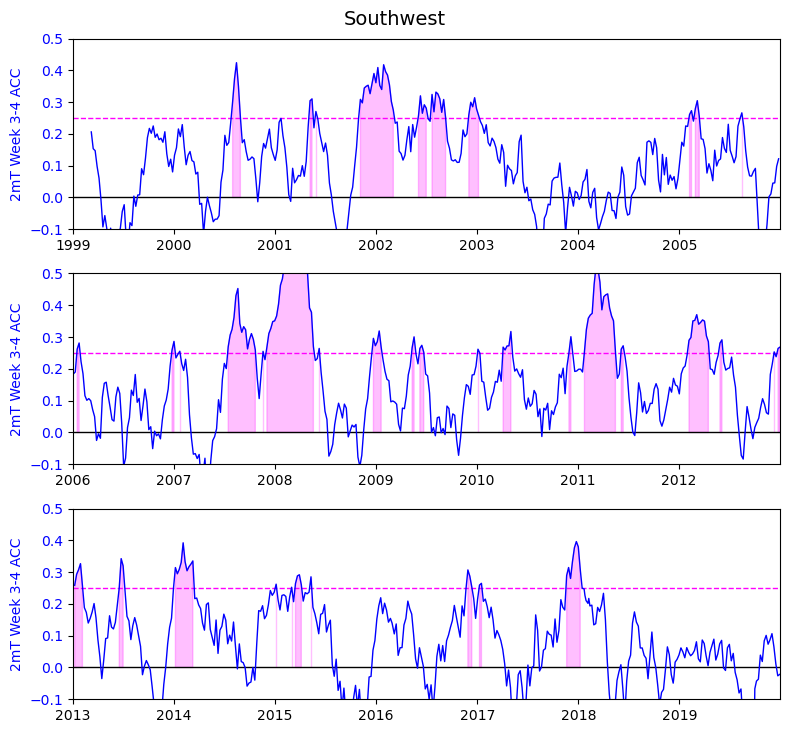

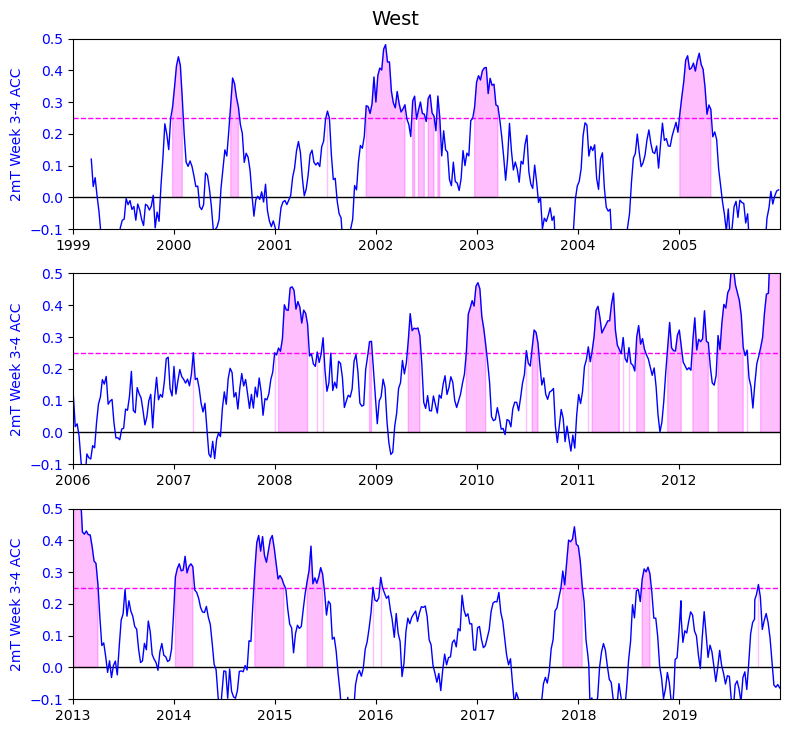

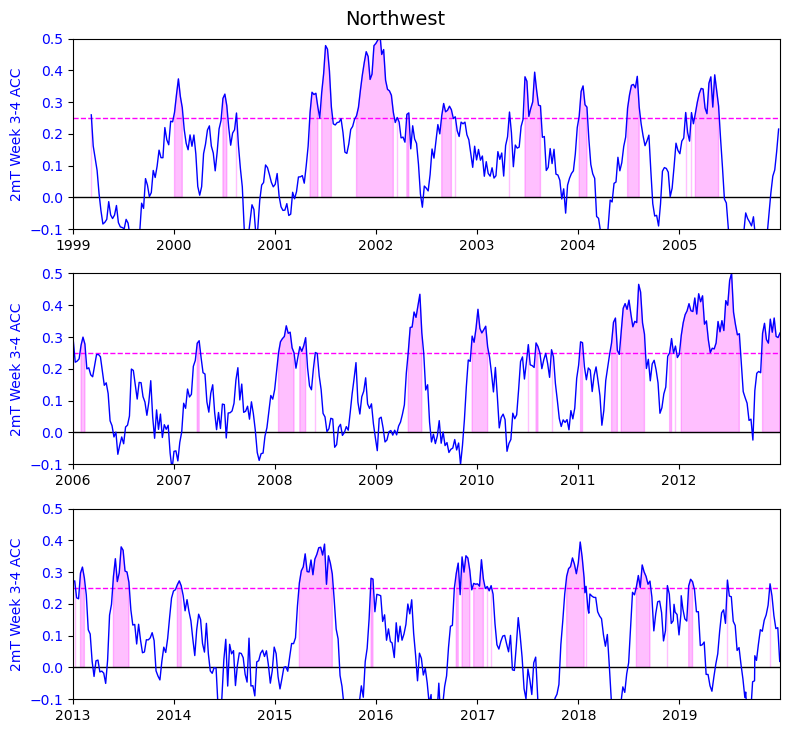

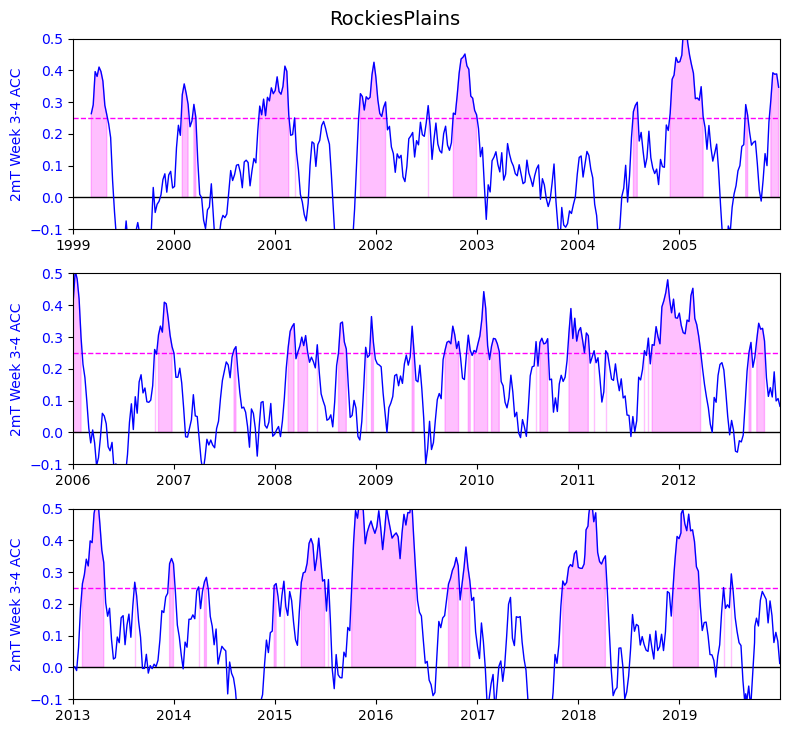

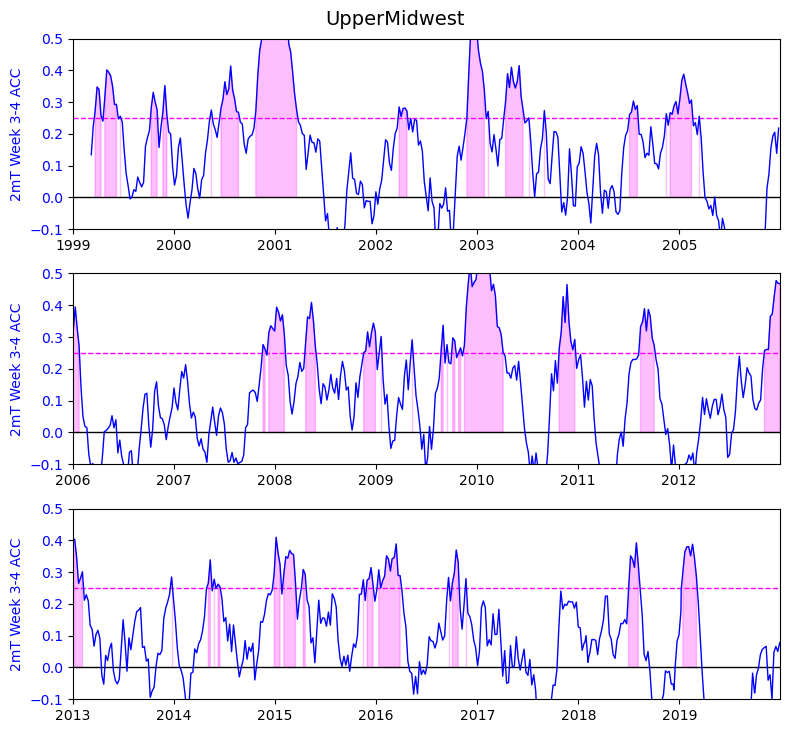

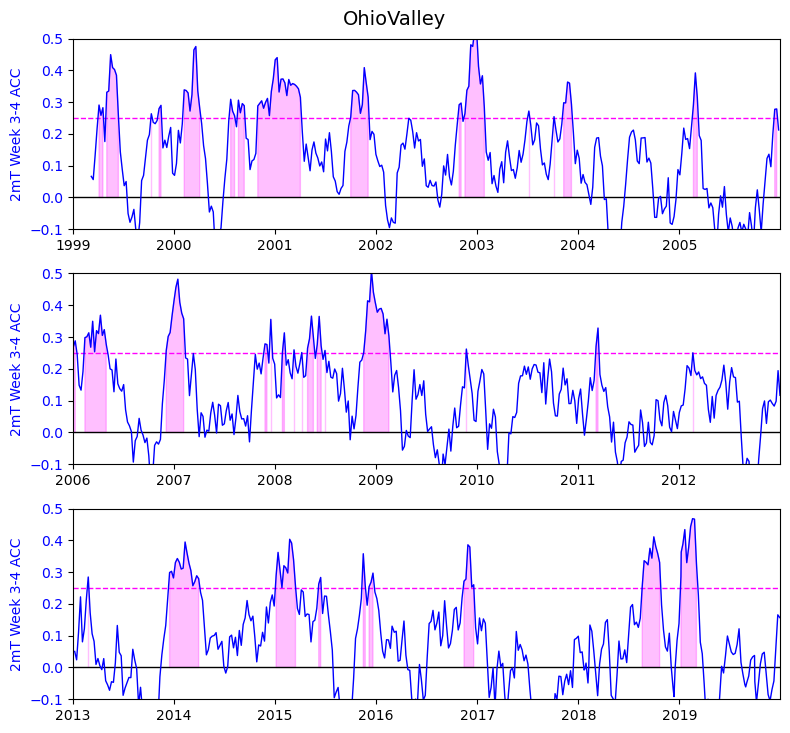

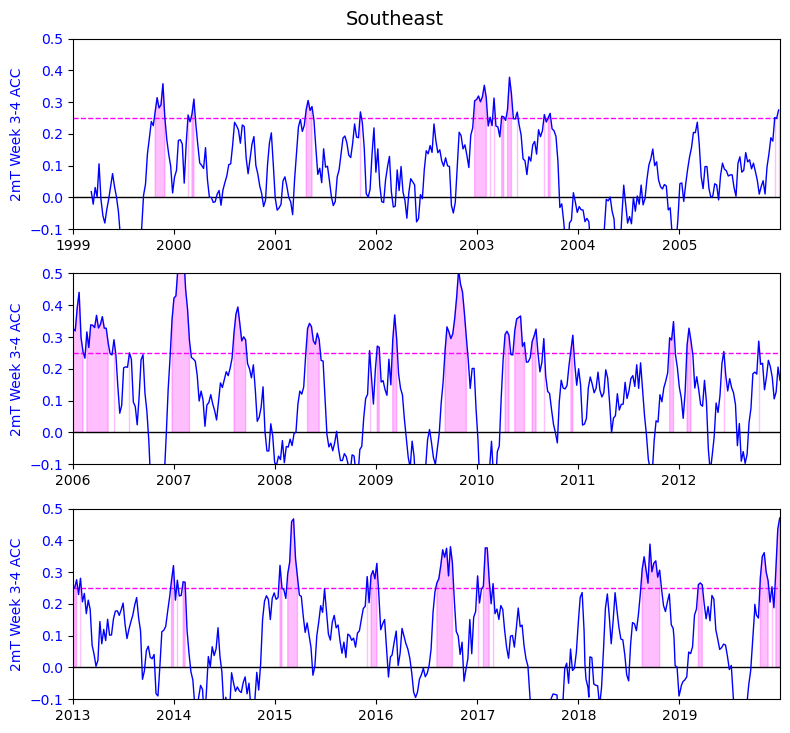

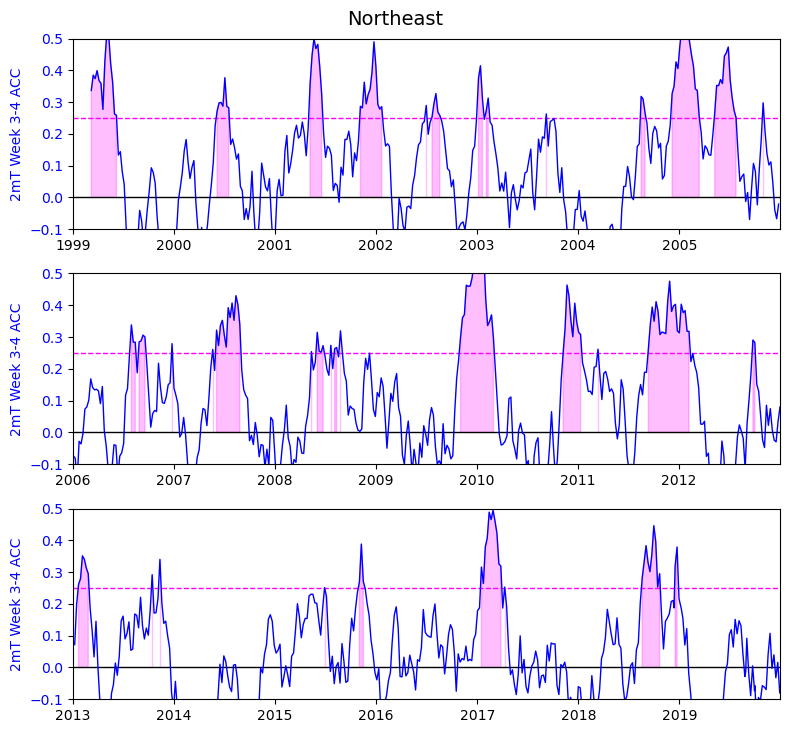

In [36]:
%reset -f
import xarray as xr
import regionmask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fileSIM = '/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/tas_2m_anom_cesm2cam6v2.scenario1_s2s_data.nc'
ds = xr.open_dataset(fileSIM)
initSIM = pd.to_datetime(ds['date'], format='%Y%m%d')
M = len(initSIM)
dateArraySIM = np.zeros((M, 46), dtype='datetime64[D]')
for i in range(46):
    dateArraySIM[:, i] = initSIM + pd.Timedelta(days=i)

region_groups = {
    'South': ['Kansas', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana', 'Mississippi'],
    'Southwest': ['Colorado', 'Arizona', 'Utah', 'New Mexico'],
    'West': ['California', 'Nevada'],
    'Northwest': ['Washington', 'Oregon', 'Idaho'],
    'RockiesPlains': ['Montana', 'Wyoming', 'North Dakota', 'South Dakota', 'Nebraska'],
    'UpperMidwest': ['Minnesota', 'Iowa', 'Wisconsin', 'Michigan'],
    'OhioValley': ['Missouri', 'Illinois', 'Indiana', 'Ohio', 'West Virginia', 'Kentucky', 'Tennessee'],
    'Southeast': ['Alabama', 'Georgia', 'Florida', 'South Carolina', 'North Carolina', 'Virginia'],
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'New York', 'Pennsylvania', 'Maryland', 
                  'Delaware', 'New Jersey', 'Connecticut', 'Rhode Island', 'Massachusetts', 'District of Columbia']
}

ds = xr.open_zarr("2mT_ACC_week34_byRegion_data.zarr")
for region_name in region_groups:
    R = ds[region_name]

    Rsmoothed = np.full(len(dateArraySIM), np.nan)
    for i in range(5, len(R) - 5): # smoothing
        Rsmoothed[i] = sum(R[i-5:i+6]) / 11

    Rplot = Rsmoothed

    fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharey=True)
    time_ranges = [
        (pd.Timestamp('1999-01-01'), pd.Timestamp('2005-12-31')),
        (pd.Timestamp('2006-01-01'), pd.Timestamp('2012-12-31')),
        (pd.Timestamp('2013-01-01'), pd.Timestamp('2019-12-31'))]
    dates = pd.to_datetime(dateArraySIM[:, 0])
    for i, ax1 in enumerate(axs):
        # ----------- filter data for this time range
        t_start, t_end = time_ranges[i]
        mask = (dates >= t_start) & (dates <= t_end)
        # ----------- left y-axis for R
        ax1.axhline(y=0, color='black', linewidth=1, linestyle='-')
        ax1.axhline(y=0.25, color='magenta', linewidth=1, linestyle='--')
        ax1.plot(dates[mask], Rplot[mask], color='blue', linewidth=1)
        ax1.set_xlim(t_start, t_end)
        ax1.set_ylim([-0.1, 0.5])
        ax1.set_ylabel('2mT Week 3-4 ACC', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        # ----------- highlight where R > XXX
        ax1.fill_between(dates[mask], Rplot[mask], where=Rplot[mask] > 0.25, color='magenta', alpha=0.25)
        # ----------- right y-axis for ENSO
        # ax2 = ax1.twinx()
        # ax2.plot(dateArrayENSO, enso, color='black', linewidth=2)
        # ax2.set_ylim([-2, 2])
        # ax2.set_ylabel('ENSO', color='black')
        # ax2.tick_params(axis='y', labelcolor='black')
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.suptitle(region_name, fontsize=14, y=0.94)  # y controls vertical position
    plt.savefig("2mT_ACCsmooth_week34_timeseries_"+ region_name +".png", dpi=300)
    plt.show()


In [2]:
# Spare notes


# var = ds['anom'].isel(lead=slice(14, 21)).mean(dim='lead')  # -------- SPECIFY days 15-28

# dateSIM = pd.to_datetime([(str(s)[:10]) for s in init])
# print(dateArrayOBS.dtype)
# print(test[0].dtype)



# bounds = np.arange(round(values.min() / 10) * 10, 
#                    int(np.ceil((values.max() + 10) / 10) * 10), 1)


# nino34_data = []
# with open('/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/nino34_obs.txt', 'r') as file:
#     for line in file:
#         values = line.split()
#         nino34_data.extend(map(float, values[1:]))
# enso = np.array(nino34_data)
# enso = enso - enso.mean(axis=0)
# dateArrayENSO = pd.date_range(start='1999-01', periods=264, freq='MS')

# highlight R>0.5
# for j in range(2, len(Rsmoothed)):
#     if (Rsmoothed[j] > 0.25) and (t_start <= dates[j] <= t_end):
#         ax1.axvspan(dates[j-1], dates[j+1], color='magenta', alpha=0.2, ymin=0.0.2, ymax=1)